### Meta

In [1]:
# Autoreload modules without having to restart the notebook kernel.
# hi bilbo
%load_ext autoreload
%autoreload 2


# Plotting code stolen from Georg's notebook.
import matplotlib.pyplot as plt


%matplotlib inline
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 32}
plt.rc('font', **font)

### Imports

In [21]:
import sys
sys.path.insert(1, "..\\")


#import markov_clustering as mcl
import networkx as nx
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_style(style = "white")
import copy
import numpy as np
import time
import re


# Personal libraries
import lib.graph
import lib.files
import lib.centrality
import lib.map_names
#import lib.cluster
#import lib.plot


In [3]:
# The first network is the largest connected component containing ICP55 with inviable proteins, has edges above 900 and no degree 0 nodes.
n0 = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks("icp55-cc-900-inv.txt"))

##Load in Julian O's df of key measures calculated on icp55 connected component, edge cutoff 900, keeping inviable proteins
network = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks('icp55-cc-900-inv.txt'))
master_df = pd.read_csv(lib.files.make_path_to_dataframes('icp55-cc-900-inv.mcl-2.5.nodes.dataframe.csv'), index_col=0, header=0)

In [5]:
n0.edges()

EdgeView([('Q0010', 'Q0017'), ('Q0010', 'Q0143'), ('Q0010', 'Q0092'), ('Q0010', 'Q0182'), ('Q0010', 'Q0297'), ('Q0010', 'Q0032'), ('Q0017', 'Q0297'), ('Q0017', 'Q0143'), ('Q0017', 'Q0032'), ('Q0017', 'Q0182'), ('Q0143', 'Q0032'), ('Q0143', 'Q0092'), ('Q0143', 'Q0182'), ('Q0143', 'Q0297'), ('Q0092', 'YDR296W'), ('Q0182', 'Q0032'), ('Q0182', 'Q0297'), ('Q0297', 'Q0032'), ('Q0297', 'Q0142'), ('YPL135W', 'YCL017C'), ('YPL135W', 'YDL120W'), ('YPL135W', 'YER048W-A'), ('YPL135W', 'YGL018C'), ('YPL135W', 'YJR122W'), ('YPL135W', 'YKL040C'), ('YPL135W', 'YLL027W'), ('YPL135W', 'YLR369W'), ('YPL135W', 'YMR301C'), ('YPL135W', 'YOR196C'), ('YPL135W', 'YOR232W'), ('YPL135W', 'YPL059W'), ('YPL135W', 'YPL252C'), ('YPL135W', 'YPR067W'), ('YCL017C', 'YJR122W'), ('YCL017C', 'YLL027W'), ('YCL017C', 'YPR067W'), ('YCL017C', 'YKL192C'), ('YCL017C', 'YPL252C'), ('YCL017C', 'YKL040C'), ('YCL017C', 'YHR111W'), ('YCL017C', 'YDR376W'), ('YCL017C', 'YER048W-A'), ('YCL017C', 'YOR226C'), ('YCL017C', 'YIL003W'), ('YC

## Validating bridging centrality

I want to know if bridging centrality does what we want it to - identify nodes that "bridge" clusters.

Methods:

Successively remove highest bridging centrality nodes in order, and see how it affects:

- Number of connected components
- Clustering coefficient (average)
- Mean shortest path between nodes
- Mean shortest path between clusters

In [37]:
#Load in Julian v's computed bridging centrality
df_bridge_sort = pd.read_csv(lib.files.path_to_tables("icp55-cc-900-inv-globalbridgingcentr.csv"), index_col = 0, header = 0)
df_bridge_sort["global_bridge_cent"] = df_bridge_sort["0"]
df_bridge_sort["protein"] = list(df_bridge_sort.index)\

#sort
df_bridge_sort = df_bridge_sort.sort_values(by = ["global_bridge_cent"],
              ascending = False)
print(df_bridge_sort.head())

                     0  global_bridge_cent       protein
4932.YGR149W  0.017724            0.017724  4932.YGR149W
4932.YHR181W  0.008014            0.008014  4932.YHR181W
4932.YJL225C  0.006480            0.006480  4932.YJL225C
4932.YJR150C  0.005430            0.005430  4932.YJR150C
4932.YBR056W  0.003020            0.003020  4932.YBR056W


#### Successive removal of highest bridging centrality nodes

This analysis mimics what is performed on Hwang et al. 2006

In [38]:
###NOTE: THIS CODE WILL TAKE SEVERAL HOURS (computation of clustering coefficient is costly). YOU CAN JUST LOAD THE COMPUTED DATA IN THE CHUNK BELOW

#Make data frame to store sequential removal stats
removal_stats_df = pd.DataFrame({"protein_removed": df_bridge_sort["protein"],
                                "bridging_centrality_removed": df_bridge_sort["global_bridge_cent"],
                                "num_nodes_removed": range(len(df_bridge_sort.index) +1)[1:]})

#Sequential remove
removed_network = copy.deepcopy(network)
num_CC = []
num_singletons = []
avg_clust_coeff = []
start = time.time()
for i in range(len(removal_stats_df.index)):
#for i in range(2):
    #removed_network = network.subgraph(list(removal_stats_df.iloc[(i + 1):, removal_stats_df.columns.get_loc("protein_removed")]))
    removed_network.remove_node(removal_stats_df.iloc[i, removal_stats_df.columns.get_loc("protein_removed")])
    
    #Number of connected components
    num_CC.append(nx.number_connected_components(removed_network))
    
    #Number of singletons
    num_singletons.append(sum(np.array(list(degree for (node, degree) in removed_network.degree())) == 0))
    
    #Avg. clustering coefficient
    avg_clust_coeff.append(nx.average_clustering(removed_network))
    
end = time.time()
print(end - start)    
    
removal_stats_df["num_CC"] = num_CC
removal_stats_df["avg_clust_coeff"] = avg_clust_coeff
removal_stats_df["num_singletons"] = num_singletons



removal_stats_df.to_csv("..\\data/tables/icp55-cc-900-inv-seq_remove_bridging.csv")

ZeroDivisionError: division by zero

Text(0, 0.5, 'Avg. clustering coefficient')

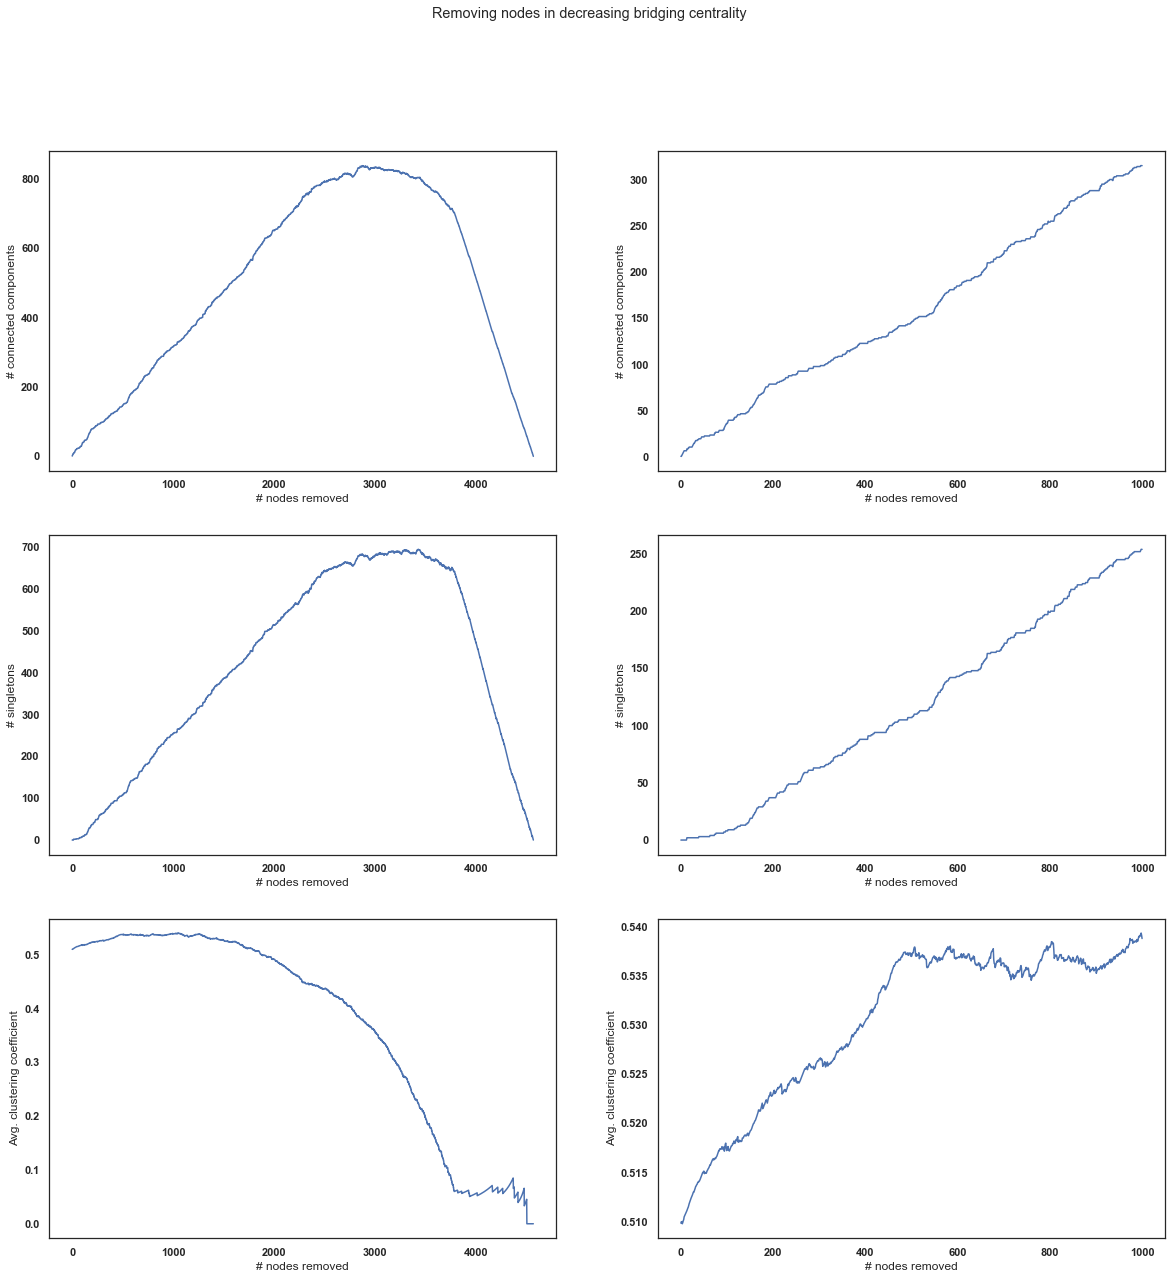

In [99]:
#Load in data if needed
#removal_stats_df = pd.read_csv("..\\data/tables/icp55-cc-900-inv-seq_remove_bridging.csv")

#Plot
fig, axes = plt.subplots(3, 2, figsize = (20, 20))
fig.suptitle("Removing nodes in decreasing bridging centrality")

sns.lineplot(data = removal_stats_df,
         x = "num_nodes_removed",
                   y = "num_CC",
            ax = axes[0, 0])
axes[0, 0].set_xlabel("# nodes removed")
axes[0, 0].set_ylabel("# connected components")

sns.lineplot(data = removal_stats_df,
         x = "num_nodes_removed",
                   y = "num_singletons",
            ax = axes[1, 0])
axes[1, 0].set_xlabel("# nodes removed")
axes[1, 0].set_ylabel("# singletons")

sns.lineplot(data = removal_stats_df,
         x = "num_nodes_removed",
                   y = "avg_clust_coeff",
            ax = axes[2, 0])
axes[2, 0].set_xlabel("# nodes removed")
axes[2, 0].set_ylabel("Avg. clustering coefficient")

sns.lineplot(data = removal_stats_df.iloc[0:999, ],
         x = "num_nodes_removed",
                   y = "num_CC",
            ax = axes[0, 1])
axes[0, 1].set_xlabel("# nodes removed")
axes[0, 1].set_ylabel("# connected components")

sns.lineplot(data = removal_stats_df.iloc[0:999, ],
         x = "num_nodes_removed",
                   y = "num_singletons",
            ax = axes[1, 1])
axes[1, 1].set_xlabel("# nodes removed")
axes[1, 1].set_ylabel("# singletons")

sns.lineplot(data = removal_stats_df.iloc[0:999, ],
         x = "num_nodes_removed",
                   y = "avg_clust_coeff",
            ax = axes[2, 1])
axes[2, 1].set_xlabel("# nodes removed")
axes[2, 1].set_ylabel("Avg. clustering coefficient")



The right column shows only the removal of the top 1000 bridging nodes. I think this is more informative.

We see that as bridging nodes are removed, the number of connected components increases, indicating the network becomes fractured. Initially (for the first ~180 nodes) there is only minimal increase in the number of singletons, suggesting this fracturing is not characterised by disconnecting single nodes.

Clustering coefficient increases steadily over the first 1000 nodes, suggesting the network is become more clustered (as we would expect). It then decreases past the first 1000 nodes.

#### Are bridging nodes in clusters?

Ideally, bridging nodes should be positioned between clusters, not within them. I test that here.

In [102]:
###Plot bridging centrality and cluster size

#Remove the 3 very high outliers
sns.relplot(data = df_bridge_sort,
           x = "global_bridge_cent",
           y = "cluster_size")


#Plot between quantiles
##THIS IS NOT REALLY WORKING - MAYBE BECAUSE THEY ARE VERY SMALL VALUES?
num_quantiles = 4
for i in range(num_quantiles):
    
    upper_quant = df_bridge_sort["global_bridge_cent"].quantile((i + 1)/num_quantiles)
    lower_quant = df_bridge_sort["global_bridge_cent"].quantile((i)/num_quantiles)
    print(lower_quant)
    print(upper_quant)
    print(len(df_bridge_sort.loc[(df_bridge_sort["global_bridge_cent"] <= upper_quant) & (df_bridge_sort["global_bridge_cent"] > lower_quant), ].index))
    
    sns.relplot(data = df_bridge_sort.loc[(df_bridge_sort["global_bridge_cent"] <= upper_quant) & (df_bridge_sort["global_bridge_cent"] > lower_quant), ],
           x = "global_bridge_cent",
           y = "cluster_size")

ValueError: Could not interpret value `cluster_size` for parameter `y`

So there is a trend for higher bridging centrality nodes to be in smaller clusters. But it is certainly just a trend.

In [175]:
master_df.head()

,protein,degree,inviable,icp55_shell,pim1_shell,betweenness,eigenvector,closeness,bridging,cluster_id,cluster_size,cluster_degree,cluster_eigenvector,cluster_closeness,betweenness/min-shell,closeness/min-shell,eigenvector/min-shell,bridging/min-shell,min-shell
0,Q0143,6,0,6,6,0.001093,1.901319e-08,0.158254,0.000144,0,8,6,0.416800,0.875000,0.000182,0.026376,3.168865e-09,0.000024,6
1,Q0017,5,0,7,7,0.000000,2.365411e-10,0.136656,0.000000,0,8,5,0.390633,0.777778,0.000000,0.019522,3.379159e-11,0.000000,7
2,Q0010,6,0,6,6,0.001093,1.901319e-08,0.158254,0.000144,0,8,6,0.416800,0.875000,0.000182,0.026376,3.168865e-09,0.000024,6
3,Q0092,3,0,5,5,0.003059,3.093142e-06,0.187914,0.002549,0,8,2,0.161351,0.538462,0.000612,0.037583,6.186284e-07,0.000510,5
4,Q0032,5,0,7,7,0.000000,2.365411e-10,0.136656,0.000000,0,8,5,0.390633,0.777778,0.000000,0.019522,3.379159e-11,0.000000,7


## Exploring clusters related to ICP55 and PIM1

### Explore network of ICP55 and PIM1 2nd shell neighbours and clusters

In [70]:
###Function: concatenate a list of proteins
def protein_concatenator(protein_list):
    
    if len(protein_list) == 0:
        return("")
    
    else:    
        for i in range(len(protein_list)):
            if i == 0:
                concatenated = str(protein_list[i])
            else:
                concatenated = str(concatenated) + ";" + str(protein_list[i])

        return(concatenated)

In [82]:
###Criteria:
#Cluster has one node path length 2 or less from icp55/pim1
#Cluster size >= 5
clusters_pl2away = list(dict.fromkeys(master_df[((master_df["icp55_shell"] <= 2) | 
                                                 (master_df["pim1_shell"] <= 2)) &
                                                (master_df["cluster_size"] >= 5)]["cluster_id"]))

###Make cluster summary df
clusters_pl2away_df = pd.DataFrame({"cluster_id": clusters_pl2away})
clusters_pl2away_df["cluster_size"] = 0
clusters_pl2away_df["3mostcentral_closeness_proteins"] = ""
clusters_pl2away_df["3mostcentral_closeness_genes"] = ""
clusters_pl2away_df["3mostcentral_closeness_descriptions"] = ""
clusters_pl2away_df["3mostcentral_eigenvector_proteins"] = ""
clusters_pl2away_df["3mostcentral_eigenvector_genes"] = ""
clusters_pl2away_df["3mostcentral_eigenvector_descriptions"] = ""
clusters_pl2away_df["icp55_pl2away_proteins"] = ""
clusters_pl2away_df["pim1_pl2away_proteins"] = ""


###Add size, and top three most central proteins (by cluster eigenvector and closeness)
for i in range(len(clusters_pl2away_df.index)):
    cluster_id = clusters_pl2away_df.iloc[i, 0]
    
    #Df of all in cluster
    cluster_df = master_df[master_df["cluster_id"]  == cluster_id]
    
    #Assign cluster size
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("cluster_size")] = list(cluster_df["cluster_size"])[0]
    
    #Assign top 3 closeness nodes
    top_closeness_proteins = list(cluster_df.sort_values(by = ["cluster_closeness"],
                                                                       ascending = False).iloc[0:3, master_df.columns.get_loc("protein")])
    top_closeness_genes = lib.map_names.map_names_descriptions(names = top_closeness_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "gene_name")
    top_closeness_descriptions = lib.map_names.map_names_descriptions(names = top_closeness_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "description")
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_closeness_proteins")] = protein_concatenator(top_closeness_proteins)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_closeness_genes")] = protein_concatenator(top_closeness_genes)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_closeness_descriptions")] = protein_concatenator(top_closeness_descriptions)
    #Assign top 3 eigenvector nodes
    top_eigenvector_proteins = list(cluster_df.sort_values(by = ["cluster_eigenvector"],
                                                                       ascending = False).iloc[0:3, master_df.columns.get_loc("protein")])
    top_eigenvector_genes = lib.map_names.map_names_descriptions(names = top_eigenvector_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "gene_name")
    top_eigenvector_descriptions = lib.map_names.map_names_descriptions(names = top_eigenvector_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "description")
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_eigenvector_proteins")] = protein_concatenator(top_eigenvector_proteins)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_eigenvector_genes")] = protein_concatenator(top_eigenvector_genes)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_eigenvector_descriptions")] = protein_concatenator(top_eigenvector_descriptions)
    
    #Get the specific proteins within path length 2 of icp55 or pim1
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("icp55_pl2away_proteins")] = protein_concatenator(list(cluster_df[cluster_df["icp55_shell"] <= 2]["protein"]))
    #Get the specific proteins within path length 2 of icp55 or pim1
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("pim1_pl2away_proteins")] = protein_concatenator(list(cluster_df[cluster_df["pim1_shell"] <= 2]["protein"]))
    
###Output
clusters_pl2away_df.to_csv("..\\data/tables/icp55-cc-900-inv.mcl-2.5.icp55pim1pl2.clusters.csv")

#### Looking into interesting proteins

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

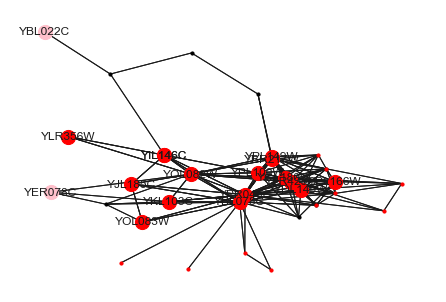

In [170]:
###Cluster 80
lib.plot.targets_with_clusters('icp55-cc-900-inv', 'mcl-2.5', ['YIL146C', "YKL103C", "YOL082W", "YPR049C", "YGL180W", "YLR423C", "YJL185C", "YOL083W", "YPL166W", "YPL149W", "YLR356W", "YIL146C", "YBR217W", "YDL149W", "YPL100W", "YBL078C"], ax=None, top_size=200, target_size=200)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

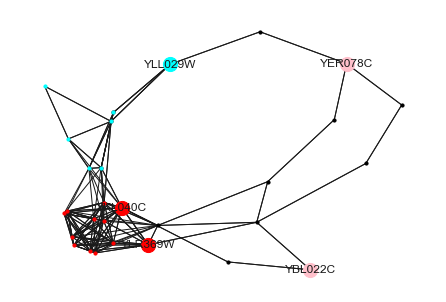

In [174]:
###Clusters 1 and 4
lib.plot.targets_with_clusters('icp55-cc-900-inv', 'mcl-2.5', ["YLL029W", "YLR369W","YKL040C"], ax=None, top_size=200, target_size=200)

In [44]:
#Comparing shortest paths for nodes and clusters
print(df[df["pim1_shortest_path"] <= 1])
print(cluster_df[cluster_df["pim1_shorpl"] <= 1])

           protein  deg  global_bet_cent  global_eig_cent  global_bridge_cent  \
25    4932.YGL043W   52         0.001266     2.650834e-04        7.663277e-07   
26    4932.YBL022C    9         0.001879     9.201928e-06        2.124451e-04   
37    4932.YER164W   46         0.001789     6.615033e-04        5.265994e-06   
1107  4932.YLR259C   62         0.013943     5.610348e-04        8.691371e-04   
1300  4932.YBR227C    7         0.000252     1.804154e-06        0.000000e+00   
1355  4932.YMR089C    5         0.000040     8.562936e-07        0.000000e+00   
1357  4932.YER017C    7         0.000080     1.076970e-06        0.000000e+00   
1403  4932.YPR024W   13         0.001712     3.830463e-06        3.285593e-05   
1914  4932.YDL015C   11         0.002579     1.038764e-05        6.772538e-05   
1915  4932.YNL295W    3         0.000459     5.851539e-08        4.528267e-05   

      icp55_shortest_path  pim1_shortest_path  inv  cluster  mcl_bet_cent  \
25                      4      

## Assessing different channels of evidence
Here I load the STRING network that is expanded to show channels of evidence (e.g. biochemical evidence of interaction, comentioning in abstracts, etc.)

In [52]:
###Load in data
string_channels_raw = pd.read_csv("..\\data/4932.protein.links.detailed.v11.5.txt",
                                 sep = " ",
                                 header = None)

In [53]:
####Process

###Change column names
string_channels_raw = string_channels_raw.set_axis(["node1", 
                                  "node2",
                                 "Neighborhood_in_the_Genome",
                                 "Gene_Fusions",
                                 "Cooccurence_Across_Genomes",
                                 "Co-Expression",
                                 "Experimental/Biochemical_Data",
                                 "Association_in_Curated_Databases",
                                 "Co-Mentioned_in_Pubmed_Abstracts",
                             "Combined_Score"],
                            axis = 1)

###Remove 4932 and combine coexp, exper, curated
string_channels_raw["coexp_expbioc_curat_sum"] = 0
for i in range(len(string_channels_raw.index)):
#for i in range(5):
    string_channels_raw.iloc[i, string_channels_raw.columns.get_loc("node1")] = re.sub("4932\\.", "", string_channels_raw.iloc[i, 0])
    string_channels_raw.iloc[i, string_channels_raw.columns.get_loc("node2")] = re.sub("4932\\.", "", string_channels_raw.iloc[i, 1])
    string_channels_raw.iloc[i, string_channels_raw.columns.get_loc("coexp_expbioc_curat_sum")] = string_channels_raw.iloc[i, string_channels_raw.columns.get_loc("Co-Expression")] +string_channels_raw.iloc[i, string_channels_raw.columns.get_loc("Experimental/Biochemical_Data")] +string_channels_raw.iloc[i, string_channels_raw.columns.get_loc("Association_in_Curated_Databases")]
    
    
print(string_channels_raw.head())

string_channels_raw.to_csv("..\\data/4932.protein.links.detailed.v11.5.processed.1.csv")

KeyboardInterrupt: 

In [41]:
###Positive controls

##PIM1 and MXC1
#Looks good
print(string_channels_raw[(string_channels_raw["node1"] == "4932.YBL022C") &
                   (string_channels_raw["node2"] == "4932.YBR227C")])

##PIM1 and TSC13
print(string_channels_raw[(string_channels_raw["node1"] == "4932.YBL022C") &
                   (string_channels_raw["node2"] == "4932.YDL015C")])

              node1         node2  Neighborhood_in_the_Genome  Gene_Fusions  \
43202  4932.YBL022C  4932.YBR227C                         191           239   

       Cooccurence_Across_Genomes  Co-Expression  \
43202                           0            307   

       Experimental/Biochemical_Data  Association_in_Curated_Databases  \
43202                            421                                 0   

       Co-Mentioned_in_Pubmed_Abstracts  Combined_Score  
43202                               813             945  
              node1         node2  Neighborhood_in_the_Genome  Gene_Fusions  \
43176  4932.YBL022C  4932.YDL015C                           0             0   

       Cooccurence_Across_Genomes  Co-Expression  \
43176                           0             47   

       Experimental/Biochemical_Data  Association_in_Curated_Databases  \
43176                            963                                 0   

       Co-Mentioned_in_Pubmed_Abstracts  Combined_Score  
